In [1]:
import os

my_data_dir = '10000_uniforme_10_a_200__centreGeom_kBFS/'
os.listdir(my_data_dir) 


['10_a_200.ods',
 'csv',
 'deuxCanaux',
 'excentricites_centreGeom.csv',
 'excentricites_kBFS.csv',
 'mixte',
 'test',
 'train',
 'validation']

In [2]:
train_dir = my_data_dir+'deuxCanaux/train/'
validation_dir = my_data_dir+'deuxCanaux/validation/'
os.listdir(train_dir)

['centreGeom', 'kBFS']

In [3]:
os.listdir(validation_dir)

['centreGeom', 'kBFS']

In [3]:
os.listdir(train_dir+'centreGeom')[1]

'essai0_10.png'

In [4]:
from matplotlib.image import imread

im1 = train_dir+'centreGeom/essai0_10.png'
imread(im1)


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

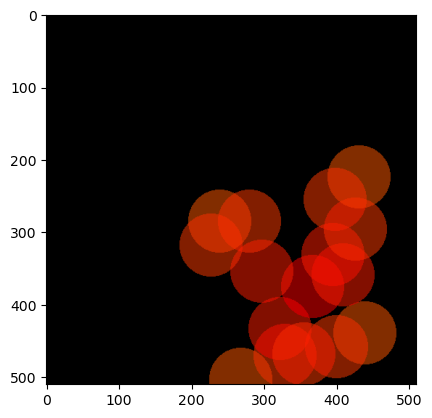

In [5]:
import matplotlib.pyplot as plt

tabIm1=imread(im1)
plt.imshow(tabIm1)

In [7]:
tabIm1.shape

(510, 510, 3)

In [6]:
###ResNet 34
from functools import partial
import tensorflow as tf 

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]
            
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'activation': self.activation,
            'main_layers': self.main_layers,
            'skip_layers': self.skip_layers
        })
        return config

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
    
    
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                        

In [7]:
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])

In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=80)
validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
#    target_size=(510,510),
    batch_size=16,
    class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
#    target_size=(510,510),
    batch_size=16,
    class_mode='binary')

#    color_mode='grayscale',

Found 10000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [9]:
results = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator, verbose=2)#, callbacks=[early_stop]

Epoch 1/20
625/625 - 798s - loss: 0.5889 - acc: 0.7185 - val_loss: 0.5929 - val_acc: 0.7112 - 798s/epoch - 1s/step
Epoch 2/20
625/625 - 797s - loss: 0.5475 - acc: 0.7458 - val_loss: 0.8547 - val_acc: 0.5804 - 797s/epoch - 1s/step
Epoch 3/20
625/625 - 830s - loss: 0.5152 - acc: 0.7674 - val_loss: 1.2349 - val_acc: 0.5340 - 830s/epoch - 1s/step
Epoch 4/20
625/625 - 825s - loss: 0.5004 - acc: 0.7713 - val_loss: 0.5251 - val_acc: 0.7400 - 825s/epoch - 1s/step
Epoch 5/20
625/625 - 830s - loss: 0.4878 - acc: 0.7850 - val_loss: 0.4722 - val_acc: 0.7836 - 830s/epoch - 1s/step
Epoch 6/20
625/625 - 819s - loss: 0.4832 - acc: 0.7804 - val_loss: 0.4730 - val_acc: 0.7860 - 819s/epoch - 1s/step
Epoch 7/20
625/625 - 819s - loss: 0.4775 - acc: 0.7919 - val_loss: 0.4422 - val_acc: 0.7996 - 819s/epoch - 1s/step
Epoch 8/20
625/625 - 806s - loss: 0.4663 - acc: 0.7899 - val_loss: 0.4284 - val_acc: 0.8180 - 806s/epoch - 1s/step
Epoch 9/20
625/625 - 784s - loss: 0.4688 - acc: 0.7911 - val_loss: 0.4355 - val_

In [10]:
#Sauvegarde
from tensorflow.keras.models import load_model
model.save('10000_images_10a200_deuxCanaux_ResNet34_20_epochs.h5')

## Evaluation du modèle

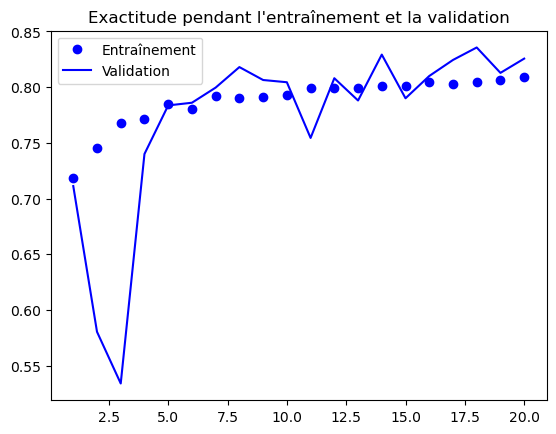

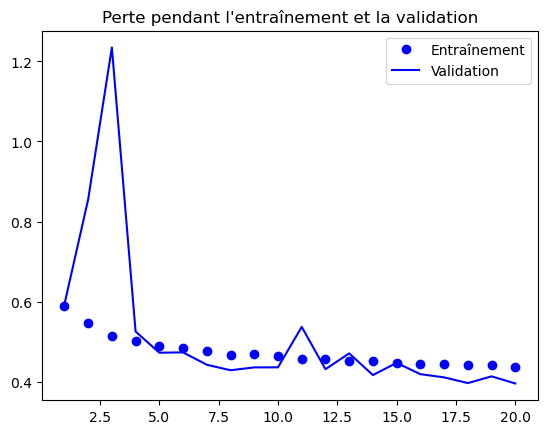

In [11]:
import matplotlib.pyplot as plt
accuracy = results.history["acc"]
val_accuracy = results.history["val_acc"]
loss = results.history["loss"]
val_loss = results.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Entraînement")
plt.plot(epochs, val_accuracy, "b", label="Validation")
plt.title("Exactitude pendant l'entraînement et la validation")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Entraînement")
plt.plot(epochs, val_loss, "b", label="Validation")
plt.title("Perte pendant l'entraînement et la validation")
plt.legend()
plt.show()

In [14]:
test_dir = my_data_dir+'deuxCanaux/test/'

test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='binary')

Found 2500 images belonging to 2 classes.


In [15]:
model.evaluate(test_generator)

157/157 [==============================] - 49s 311ms/step - loss: 0.4049 - acc: 0.8176


[0.4049091637134552, 0.8176000118255615]

In [17]:
res = model.predict(test_generator)
probas = [k[0] for k in res]



157/157 [==============================] - 54s 341ms/step


In [19]:
sum(probas)/len(probas)

0.37699846668019893